# Problem Statement

Congratulations – you have been hired as Chief Data Scientist of MedCamp – a not for profit organization dedicated in making health conditions for working professionals better. MedCamp was started because the founders saw their family suffer due to bad work life balance and neglected health.

MedCamp organizes health camps in several cities with low work life balance. They reach out to working people and ask them to register for these health camps. For those who attend, MedCamp provides them facility to undergo health checks or increase awareness by visiting various stalls (depending on the format of camp).

MedCamp has conducted 65 such events over a period of 4 years and they see a high drop off between “Registration” and Number of people taking tests at the Camps. In last 4 years, they have stored data of ~110,000 registrations they have done.

One of the huge costs in arranging these camps is the amount of inventory you need to carry. If you carry more than required inventory, you incur unnecessarily high costs. On the other hand, if you carry less than required inventory for conducting these medical checks, people end up having bad experience.

#### The Process:

MedCamp employees / volunteers reach out to people and drive registrations.
During the camp, People who “ShowUp” either undergo the medical tests or visit stalls depending on the format of health camp.

#### Other things to note:

Since this is a completely voluntary activity for the working professionals, MedCamp usually has little profile information about these people.
For a few camps, there was hardware failure, so some information about date and time of registration is lost.
MedCamp runs 3 formats of these camps. The first and second format provides people with an instantaneous health score. The third format provides information about several health issues through various awareness stalls.

#### Favorable outcome:

For the first 2 formats, a favourable outcome is defined as getting a health_score, while in the third format it is defined as visiting at least a stall.
You need to predict the chances (probability) of having a favourable outcome.

#### Train / Test split:

Camps started on or before 31st March 2006 are considered in Train
Test data is for all camps conducted on or after 1st April 2006.



# Data Loading

In [ ]:
#importing useful libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
#reading csv
health_camp_detail = pd.read_csv('Health_Camp_Detail.csv')
patient_profile = pd.read_csv('Patient_Profile.csv')
fhc = pd.read_csv('First_Health_Camp_Attended.csv')
shc = pd.read_csv('Second_Health_Camp_Attended.csv')
thc = pd.read_csv('Third_Health_Camp_Attended.csv')
train = pd.read_csv('Train.csv')
test = pd.read_csv('test.csv')


# Health Camp Detail

In [ ]:
health_camp_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Health_Camp_ID   65 non-null     int64 
 1   Camp_Start_Date  65 non-null     object
 2   Camp_End_Date    65 non-null     object
 3   Category1        65 non-null     object
 4   Category2        65 non-null     object
 5   Category3        65 non-null     int64 
dtypes: int64(2), object(4)
memory usage: 3.2+ KB


In [ ]:
health_camp_detail.head(2)

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,6560,16-Aug-03,20-Aug-03,First,B,2
1,6530,16-Aug-03,28-Oct-03,First,C,2


## Data Preprocessing

In [ ]:
#converting string date to datetime object
health_camp_detail['Camp_Start_Date']=health_camp_detail['Camp_Start_Date'].apply(lambda x:datetime.strptime(x,'%d-%b-%y'))
health_camp_detail['Camp_End_Date']=health_camp_detail['Camp_End_Date'].apply(lambda x:datetime.strptime(x,'%d-%b-%y'))

#adding suffix for easy identification during one-hot encoding
health_camp_detail['Category1']=health_camp_detail['Category1']+'_cat1'
health_camp_detail['Category2']=health_camp_detail['Category2']+'_cat2'
health_camp_detail['Category3']=health_camp_detail['Category3'].apply(lambda x:str(x)+'_cat3')

In [ ]:
health_camp_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Health_Camp_ID   65 non-null     int64         
 1   Camp_Start_Date  65 non-null     datetime64[ns]
 2   Camp_End_Date    65 non-null     datetime64[ns]
 3   Category1        65 non-null     object        
 4   Category2        65 non-null     object        
 5   Category3        65 non-null     object        
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 3.2+ KB


In [ ]:
health_camp_detail.head(2)

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3
0,6560,2003-08-16,2003-08-20,First_cat1,B_cat2,2_cat3
1,6530,2003-08-16,2003-10-28,First_cat1,C_cat2,2_cat3


In [ ]:
health_camp_detail['Health_Camp_ID'].value_counts()

,count
Health_Camp_ID,
6560,1
6530,1
6544,1
6585,1
6561,1
...,...
6556,1
6551,1
6559,1


In [ ]:
sum(health_camp_detail['Health_Camp_ID'].value_counts()>1)
# No duplicate health camps, should not cause any issue during join

0

In [ ]:
health_camp_detail[health_camp_detail['Camp_End_Date']<health_camp_detail['Camp_Start_Date']]
# No instances of campaign end date < camp start date

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3


## Feature Engineering

In [ ]:
# Convert to datetime
health_camp_detail['Camp_Start_Date'] = pd.to_datetime(health_camp_detail['Camp_Start_Date'])
health_camp_detail['Camp_End_Date'] = pd.to_datetime(health_camp_detail['Camp_End_Date'])

# Extract date features
health_camp_detail['Camp_Start_Month'] = health_camp_detail['Camp_Start_Date'].dt.month
health_camp_detail['Camp_Start_Day'] = health_camp_detail['Camp_Start_Date'].dt.day
health_camp_detail['Camp_Start_Quarter'] = health_camp_detail['Camp_Start_Date'].dt.quarter

health_camp_detail['Camp_End_Month'] = health_camp_detail['Camp_End_Date'].dt.month
health_camp_detail['Camp_End_Day'] = health_camp_detail['Camp_End_Date'].dt.day
health_camp_detail['Camp_End_Quarter'] = health_camp_detail['Camp_End_Date'].dt.quarter

# Camp duration in days
health_camp_detail['Camp_Duration'] = (
    health_camp_detail['Camp_End_Date'] - health_camp_detail['Camp_Start_Date']
).dt.days


In [ ]:
health_camp_detail.head(2)

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Camp_Start_Month,Camp_Start_Day,Camp_Start_Quarter,Camp_End_Month,Camp_End_Day,Camp_End_Quarter,Camp_Duration
0,6560,2003-08-16,2003-08-20,First_cat1,B_cat2,2_cat3,8,16,3,8,20,3,4
1,6530,2003-08-16,2003-10-28,First_cat1,C_cat2,2_cat3,8,16,3,10,28,4,73


In [ ]:
#Creating Dummies
#Category1
category1_dummies = pd.get_dummies(health_camp_detail['Category1'],drop_first=True)
health_camp_detail = pd.concat([health_camp_detail.drop('Category1',axis=1),category1_dummies],axis=1)

#Category2
category2_dummies = pd.get_dummies(health_camp_detail['Category2'],drop_first=True)
health_camp_detail = pd.concat([health_camp_detail.drop('Category2',axis=1),category2_dummies],axis=1)

#Category3
category3_dummies = pd.get_dummies(health_camp_detail['Category3'],drop_first=True)
health_camp_detail = pd.concat([health_camp_detail.drop('Category3',axis=1),category3_dummies],axis=1)

#Weekends
health_camp_detail['weekends_during_campaign']=[pd.date_range(x,y).weekday.isin([5,6]).sum() for x , y in zip(health_camp_detail['Camp_Start_Date'],health_camp_detail['Camp_End_Date'])]


In [ ]:
health_camp_detail.head(2)

,Health_Camp_ID,Camp_Start_Date,Camp_End_Date,Camp_Start_Month,Camp_Start_Day,Camp_Start_Quarter,Camp_End_Month,Camp_End_Day,Camp_End_Quarter,Camp_Duration,Second_cat1,Third_cat1,B_cat2,C_cat2,D_cat2,E_cat2,F_cat2,G_cat2,2_cat3,weekends_during_campaign
0,6560,2003-08-16,2003-08-20,8,16,3,8,20,3,4,False,False,True,False,False,False,False,False,True,2
1,6530,2003-08-16,2003-10-28,8,16,3,10,28,4,73,False,False,False,True,False,False,False,False,True,22


## Exploratory Data Analysis

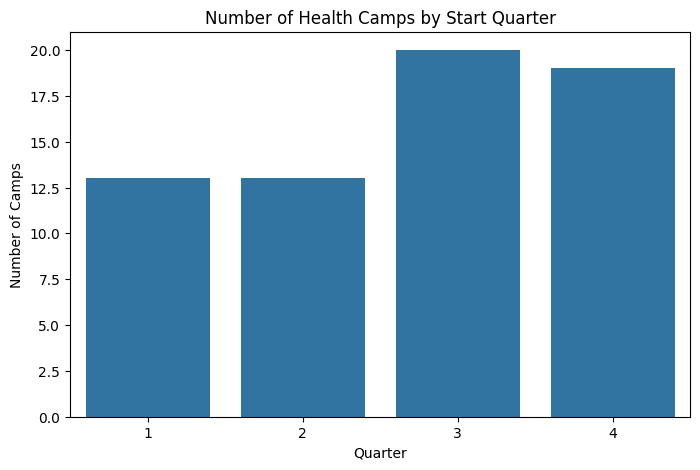

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(
    x='Camp_Start_Quarter',
    data=health_camp_detail,
    order=[1, 2, 3, 4]
)
plt.title('Number of Health Camps by Start Quarter')
plt.xlabel('Quarter')
plt.ylabel('Number of Camps')
plt.show()


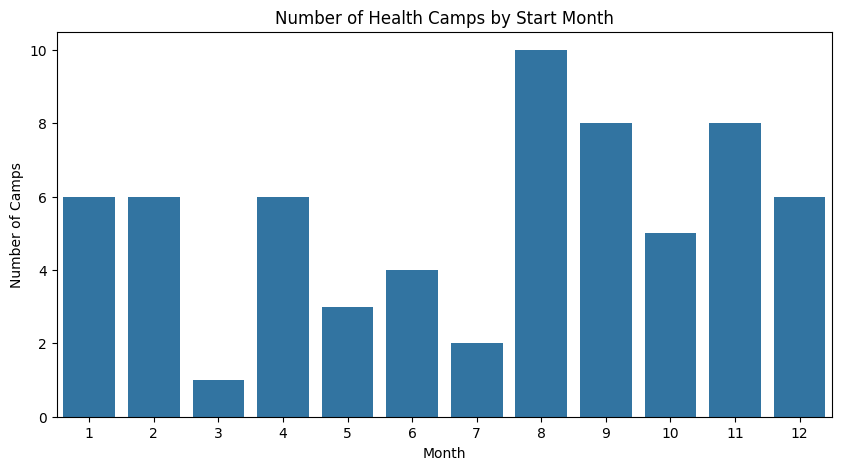

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(
    x='Camp_Start_Month',
    data=health_camp_detail,
    order=list(range(1, 13))
)
plt.title('Number of Health Camps by Start Month')
plt.xlabel('Month')
plt.ylabel('Number of Camps')
plt.show()


<Axes: ylabel='Camp_Duration'>

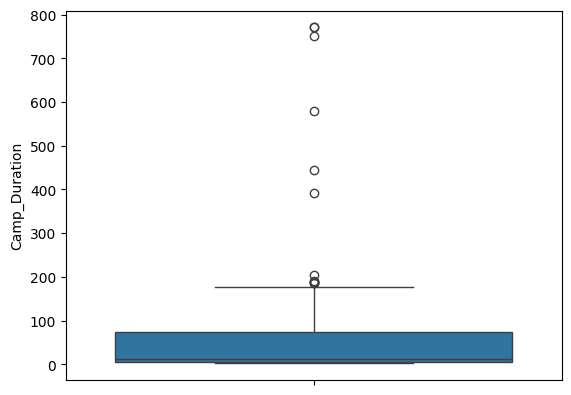

In [ ]:
#camp duration distribution
sns.boxplot(health_camp_detail['Camp_Duration'])

<Axes: ylabel='weekends_during_campaign'>

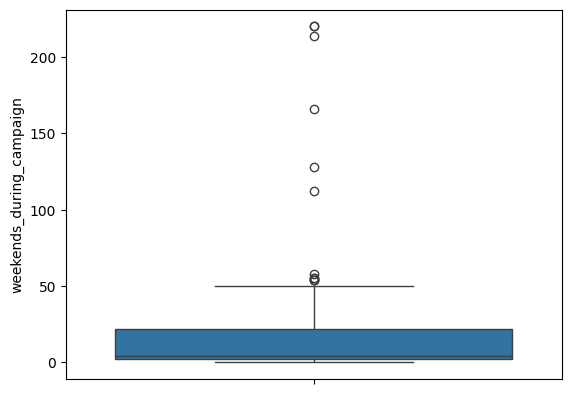

In [ ]:
#camp weekends distribution
sns.boxplot(health_camp_detail['weekends_during_campaign'])

# Patient Profile

In [ ]:
patient_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37633 entries, 0 to 37632
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Patient_ID         37633 non-null  int64  
 1   Online_Follower    37633 non-null  int64  
 2   LinkedIn_Shared    37633 non-null  int64  
 3   Twitter_Shared     37633 non-null  int64  
 4   Facebook_Shared    37633 non-null  int64  
 5   Income             4362 non-null   float64
 6   Education_Score    1384 non-null   float64
 7   Age                5015 non-null   float64
 8   First_Interaction  37633 non-null  object 
 9   City_Type          14249 non-null  object 
 10  Employer_Category  2840 non-null   object 
dtypes: float64(3), int64(5), object(3)
memory usage: 3.2+ MB


In [ ]:
patient_profile.head(2)

,Patient_ID,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category
0,516956,0,0,0,0,1.0,90.0,39.0,18-Jun-03,NaN,Software Industry
1,507733,0,0,0,0,1.0,NaN,40.0,20-Jul-03,H,Software Industry


## Data Preprocessing

In [ ]:
patient_profile['First_Interaction']=patient_profile['First_Interaction'].apply(lambda x:datetime.strptime(x,'%d-%b-%y'))

## Feature Engineering

In [ ]:
#First_Interaction_Date
patient_profile['First_Interaction_Month']=patient_profile['First_Interaction'].apply(lambda x:x.month)
patient_profile['First_Interaction_Day']=patient_profile['First_Interaction'].apply(lambda x:x.day)
patient_profile['First_Interaction_Quarter']=patient_profile['First_Interaction'].apply(lambda x:x.quarter)

#Making Education Score & Age as np.nan
patient_profile['Education_Score']=patient_profile['Education_Score'].apply(lambda x: np.nan if x=='None' else x)
patient_profile['Age']=patient_profile['Age'].apply(lambda x: np.nan if x=='None' else x)
patient_profile['Education_Score']=pd.to_numeric(patient_profile['Education_Score'], downcast="float")
patient_profile['Age']=pd.to_numeric(patient_profile['Age'], downcast="float")

#Consolidating Online Interactions
patient_profile['Online_Interactions']=patient_profile['Facebook_Shared']+patient_profile['Twitter_Shared']+patient_profile['LinkedIn_Shared']+patient_profile['Online_Follower']

In [ ]:
patient_profile['Facebook_Shared'].value_counts()

,count
Facebook_Shared,
0,36747
1,886


In [ ]:
patient_profile['Online_Follower'].value_counts()

,count
Online_Follower,
0,36785
1,848


In [ ]:
patient_profile['LinkedIn_Shared'].value_counts()

,count
LinkedIn_Shared,
0,36614
1,1019


In [ ]:
patient_profile['Twitter_Shared'].value_counts()

,count
Twitter_Shared,
0,36820
1,813


In [ ]:
patient_profile['Online_Interactions'].value_counts()

,count
Online_Interactions,
0,35943
2,579
1,538
3,422
4,151


In [ ]:
patient_profile.drop(['Facebook_Shared','Twitter_Shared','LinkedIn_Shared','Online_Follower'],axis=1,inplace=True)

In [ ]:
#Income
patient_profile['Income']=patient_profile['Income'].apply(lambda x:str(x)+'_inc')
patient_profile['Income'].value_counts()

,count
Income,
nan_inc,33271
0.0_inc,2033
1.0_inc,1013
2.0_inc,685
3.0_inc,362
4.0_inc,156
5.0_inc,70
6.0_inc,43


In [ ]:
#City_Type
patient_profile['City_Type'].value_counts()

,count
City_Type,
B,2662
H,2517
A,1729
D,1704
G,1352
E,1217
C,1216
I,1036
F,816


In [ ]:
patient_profile['City_Type']=patient_profile['City_Type'].fillna('None')

In [ ]:
patient_profile['City_Type']=patient_profile['City_Type']+'_city'

In [ ]:
#Creating Dummies
#Income
income_dummies = pd.get_dummies(patient_profile['Income'],drop_first=True)
patient_profile = pd.concat([patient_profile.drop('Income',axis=1),income_dummies],axis=1)

#City_Type
city_type_dummies = pd.get_dummies(patient_profile['City_Type'],drop_first=True)
patient_profile = pd.concat([patient_profile.drop('City_Type',axis=1),city_type_dummies],axis=1)

## Exploratory Data Analysis

In [ ]:
patient_profile.head(2)

,Patient_ID,Education_Score,Age,First_Interaction,Employer_Category,First_Interaction_Month,First_Interaction_Day,First_Interaction_Quarter,Online_Interactions,1.0_inc,...,nan_inc,B_city,C_city,D_city,E_city,F_city,G_city,H_city,I_city,None_city
0,516956,90.0,39.0,2003-06-18,Software Industry,6,18,2,0,True,...,False,False,False,False,False,False,False,False,False,True
1,507733,NaN,40.0,2003-07-20,Software Industry,7,20,3,0,True,...,False,False,False,False,False,False,False,True,False,False


In [ ]:
sum(patient_profile['Patient_ID'].value_counts()>1)
#No duplicates for patients

0

In [ ]:
#Age
patient_profile['Age'].value_counts()

,count
Age,
41.0,361
43.0,359
42.0,336
40.0,321
39.0,299
44.0,293
45.0,240
38.0,219
72.0,218


/tmp/ipython-input-504199902.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(patient_profile[(patient_profile['Age']!='None')]['Age'])


<Axes: xlabel='Age', ylabel='Density'>

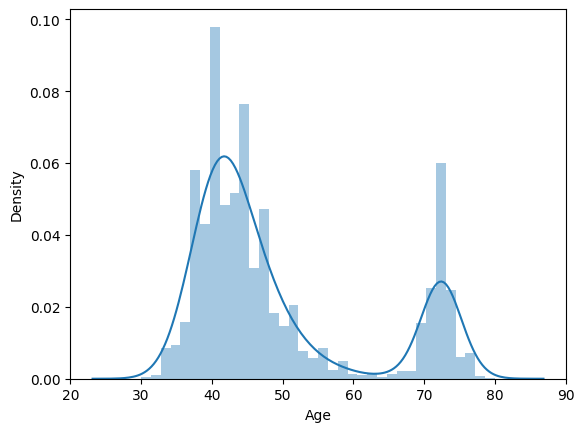

In [ ]:
sns.distplot(patient_profile[(patient_profile['Age']!='None')]['Age'])

In [ ]:
patient_profile['Age'].mean(),patient_profile['Age'].median()

(np.float32(49.12981), 44.0)

In [ ]:
#Education
patient_profile['Education_Score'].value_counts()

,count
Education_Score,
75.000000,57
82.000000,57
79.000000,52
76.000000,51
77.000000,50
...,...
81.625000,1
68.566666,1
72.220001,1


/tmp/ipython-input-895907691.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(patient_profile[(patient_profile['Education_Score']!='None')]['Education_Score'])


<Axes: xlabel='Education_Score', ylabel='Density'>

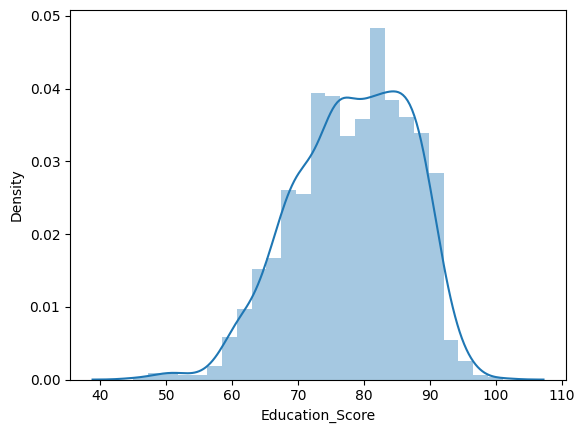

In [ ]:
sns.distplot(patient_profile[(patient_profile['Education_Score']!='None')]['Education_Score'])

In [ ]:
patient_profile['Education_Score'].mean(),patient_profile['Education_Score'].median()

(np.float32(78.231285), 79.0)

In [ ]:
patient_profile['Employer_Category'].value_counts()

,count
Employer_Category,
Technology,649
Others,477
Consulting,404
Software Industry,374
Education,188
BFSI,167
Manufacturing,115
Retail,91
Health,88


# Camp Details

In [ ]:
fhc.head(2)

,Patient_ID,Health_Camp_ID,Donation,Health_Score,Unnamed: 4
0,506181,6560,40,0.439024,NaN
1,494977,6560,20,0.097561,NaN


In [ ]:
fhc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6218 entries, 0 to 6217
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patient_ID      6218 non-null   int64  
 1   Health_Camp_ID  6218 non-null   int64  
 2   Donation        6218 non-null   int64  
 3   Health_Score    6218 non-null   float64
 4   Unnamed: 4      0 non-null      float64
dtypes: float64(2), int64(3)
memory usage: 243.0 KB


In [ ]:
fhc.drop('Unnamed: 4',inplace=True,axis=1)

In [ ]:
shc.head(2)

,Patient_ID,Health_Camp_ID,Health Score
0,526631,6536,0.875136
1,509122,6536,0.755700


In [ ]:
shc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7819 entries, 0 to 7818
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Patient_ID      7819 non-null   int64  
 1   Health_Camp_ID  7819 non-null   int64  
 2   Health Score    7819 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 183.4 KB


In [ ]:
thc.head(2)

,Patient_ID,Health_Camp_ID,Number_of_stall_visited,Last_Stall_Visited_Number
0,517875,6527,3,1
1,504692,6578,1,1


In [ ]:
thc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6515 entries, 0 to 6514
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Patient_ID                 6515 non-null   int64
 1   Health_Camp_ID             6515 non-null   int64
 2   Number_of_stall_visited    6515 non-null   int64
 3   Last_Stall_Visited_Number  6515 non-null   int64
dtypes: int64(4)
memory usage: 203.7 KB


# Train & Test

In [ ]:
train.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,489652,6578,10-Sep-05,4,0,0,0,2
1,507246,6578,18-Aug-05,45,5,0,0,7
2,523729,6534,29-Apr-06,0,0,0,0,0
3,524931,6535,07-Feb-04,0,0,0,0,0
4,521364,6529,28-Feb-06,15,1,0,0,7


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75278 entries, 0 to 75277
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient_ID         75278 non-null  int64 
 1   Health_Camp_ID     75278 non-null  int64 
 2   Registration_Date  74944 non-null  object
 3   Var1               75278 non-null  int64 
 4   Var2               75278 non-null  int64 
 5   Var3               75278 non-null  int64 
 6   Var4               75278 non-null  int64 
 7   Var5               75278 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 4.6+ MB


In [ ]:
#dropping 334 records with not registration date
train=train.dropna()

In [ ]:
train.isnull().sum()

,0
Patient_ID,0
Health_Camp_ID,0
Registration_Date,0
Var1,0
Var2,0
Var3,0
Var4,0
Var5,0


In [ ]:
test.head(2)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,505701,6548,21-May-06,1,0,0,0,2
1,500633,6584,02-Jun-06,0,0,0,0,0


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35249 entries, 0 to 35248
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Patient_ID         35249 non-null  int64 
 1   Health_Camp_ID     35249 non-null  int64 
 2   Registration_Date  35249 non-null  object
 3   Var1               35249 non-null  int64 
 4   Var2               35249 non-null  int64 
 5   Var3               35249 non-null  int64 
 6   Var4               35249 non-null  int64 
 7   Var5               35249 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 2.2+ MB


In [ ]:
#converting string date to datetime object
train['Registration_Date']=train['Registration_Date'].apply(lambda x:datetime.strptime(x,'%d-%b-%y'))
test['Registration_Date']=test['Registration_Date'].apply(lambda x:datetime.strptime(x,'%d-%b-%y'))

train['Registration_Quarter']=train['Registration_Date'].apply(lambda x:x.quarter)
test['Registration_Quarter']=test['Registration_Date'].apply(lambda x:x.quarter)

train['Registration_Month']=train['Registration_Date'].apply(lambda x:x.month)
test['Registration_Month']=test['Registration_Date'].apply(lambda x:x.month)

train['Registration_Day']=train['Registration_Date'].apply(lambda x:x.day)
test['Registration_Day']=test['Registration_Date'].apply(lambda x:x.day)

In [ ]:
train.head(2)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Registration_Quarter,Registration_Month,Registration_Day
0,489652,6578,2005-09-10,4,0,0,0,2,3,9,10
1,507246,6578,2005-08-18,45,5,0,0,7,3,8,18


In [ ]:
test.head(2)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Registration_Quarter,Registration_Month,Registration_Day
0,505701,6548,2006-05-21,1,0,0,0,2,2,5,21
1,500633,6584,2006-06-02,0,0,0,0,0,2,6,2


#### Merging with health and patient details, creating outcome variable

In [ ]:
#merging health camp details
train=pd.merge(train,health_camp_detail,how='left')
test=pd.merge(test,health_camp_detail,how='left')

#merging patient details
train=pd.merge(train,patient_profile,how='left')
test=pd.merge(test,patient_profile,how='left')

#merging fhc details
train = pd.merge(train, fhc,  how='left', left_on=['Patient_ID','Health_Camp_ID'], right_on = ['Patient_ID','Health_Camp_ID'])

#merging shc details
train = pd.merge(train, shc,  how='left', left_on=['Patient_ID','Health_Camp_ID'], right_on = ['Patient_ID','Health_Camp_ID'])

#merging thc details
train = pd.merge(train, thc,  how='left', left_on=['Patient_ID','Health_Camp_ID'], right_on = ['Patient_ID','Health_Camp_ID'])

#creating outcome value
#creating binary column for first health camp
train['fhc_outcome']=train['Health_Score'].apply(lambda x: 1 if x>0 else 0 )

#creating binary column for second health camp
train['shc_outcome']=train['Health Score'].apply(lambda x: 1 if x>0 else 0 )

#creating binary column for third health camp
train['thc_outcome']=train['Number_of_stall_visited'].apply(lambda x: 1 if x>0 else 0 )

#overall outcome
train['overall_outcome']=train['fhc_outcome']+train['shc_outcome']+train['thc_outcome']

train.drop(['fhc_outcome','shc_outcome','thc_outcome','Health_Score','Health Score','Donation','Number_of_stall_visited','Last_Stall_Visited_Number'],axis=1,inplace=True)
train['overall_outcome'].value_counts()

,count
overall_outcome,
0,54606
1,20338


# Exploring Train Data & Feature Engineering for Train

In [ ]:
train.head(2)

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Registration_Quarter,Registration_Month,...,B_city,C_city,D_city,E_city,F_city,G_city,H_city,I_city,None_city,overall_outcome
0,489652,6578,2005-09-10,4,0,0,0,2,3,9,...,False,False,False,False,False,False,False,False,True,1
1,507246,6578,2005-08-18,45,5,0,0,7,3,8,...,False,True,False,False,False,False,False,False,False,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74944 entries, 0 to 74943
Data columns (total 55 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Patient_ID                 74944 non-null  int64         
 1   Health_Camp_ID             74944 non-null  int64         
 2   Registration_Date          74944 non-null  datetime64[ns]
 3   Var1                       74944 non-null  int64         
 4   Var2                       74944 non-null  int64         
 5   Var3                       74944 non-null  int64         
 6   Var4                       74944 non-null  int64         
 7   Var5                       74944 non-null  int64         
 8   Registration_Quarter       74944 non-null  int64         
 9   Registration_Month         74944 non-null  int64         
 10  Registration_Day           74944 non-null  int64         
 11  Camp_Start_Date            74944 non-null  datetime64[ns]
 12  Camp

In [ ]:
#checking missing values
train.isnull().sum()

,0
Patient_ID,0
Health_Camp_ID,0
Registration_Date,0
Var1,0
Var2,0
Var3,0
Var4,0
Var5,0
Registration_Quarter,0
Registration_Month,0


In [ ]:
test.isnull().sum()

,0
Patient_ID,0
Health_Camp_ID,0
Registration_Date,0
Var1,0
Var2,0
Var3,0
Var4,0
Var5,0
Registration_Quarter,0
Registration_Month,0


In [ ]:
train_avg_edu=train['Education_Score'].mean()
train_avg_age=train['Age'].mean()
train['Education_Score']=train['Education_Score'].fillna(train_avg_edu)
train['Age']=train['Age'].fillna(train_avg_age)

train.isnull().sum()

,0
Patient_ID,0
Health_Camp_ID,0
Registration_Date,0
Var1,0
Var2,0
Var3,0
Var4,0
Var5,0
Registration_Quarter,0
Registration_Month,0


In [ ]:
test_avg_edu=test['Education_Score'].mean()
test_avg_age=test['Age'].mean()
test['Education_Score']=test['Education_Score'].fillna(test_avg_edu)
test['Age']=test['Age'].fillna(test_avg_age)

test.isnull().sum()

,0
Patient_ID,0
Health_Camp_ID,0
Registration_Date,0
Var1,0
Var2,0
Var3,0
Var4,0
Var5,0
Registration_Quarter,0
Registration_Month,0


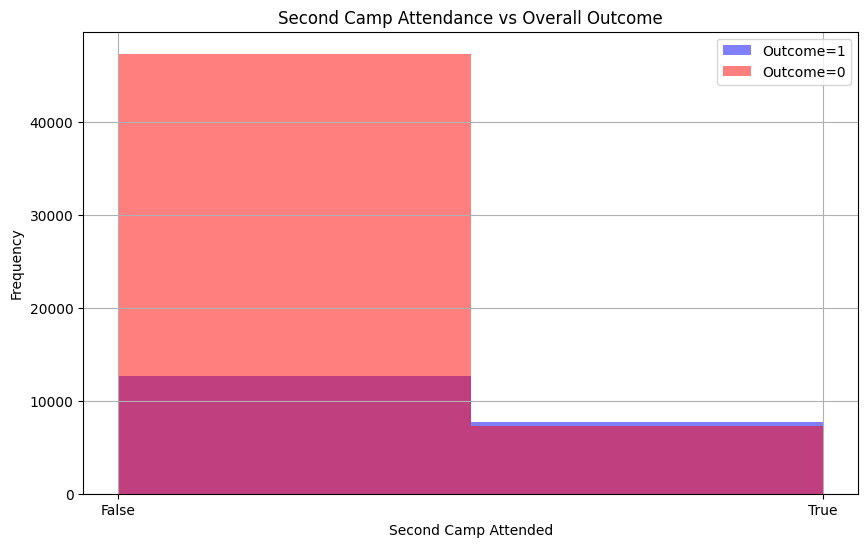

In [ ]:
import matplotlib.pyplot as plt

# Convert boolean column to integer
train['Second_cat1_int'] = train['Second_cat1'].astype(int)

plt.figure(figsize=(10,6))

train[train['overall_outcome'] == 1]['Second_cat1_int'].hist(
    alpha=0.5, color='blue', bins=2, label='Outcome=1'
)

train[train['overall_outcome'] == 0]['Second_cat1_int'].hist(
    alpha=0.5, color='red', bins=2, label='Outcome=0'
)

plt.xticks([0,1], ['False', 'True'])
plt.xlabel('Second Camp Attended')
plt.ylabel('Frequency')
plt.title('Second Camp Attendance vs Overall Outcome')
plt.legend()
plt.show()


<Axes: xlabel='Age', ylabel='Education_Score'>

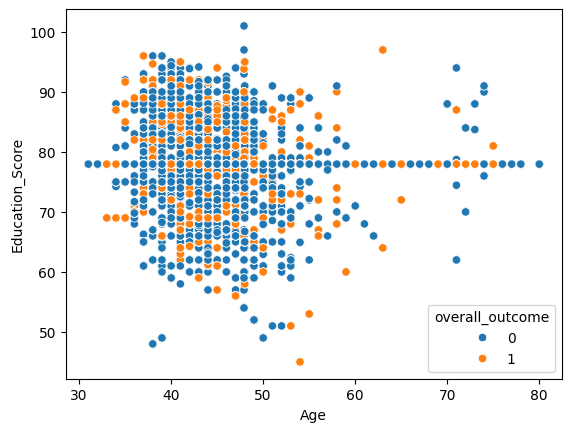

In [ ]:
sns.scatterplot(x='Age',y='Education_Score',data=train,hue='overall_outcome')

# Some Additional Feature Engineering & Exploratory Data Analysis

In [ ]:

# Ensure datetime format FIRST
date_cols = [
    'Camp_Start_Date',
    'Camp_End_Date',
    'Registration_Date',
    'First_Interaction'
]

for col in date_cols:
    train[col] = pd.to_datetime(train[col], errors='coerce')
    test[col]  = pd.to_datetime(test[col], errors='coerce')


# -----------------------------
# Registration-based features
# -----------------------------
train['regis_cs'] = (train['Camp_Start_Date'] - train['Registration_Date']).dt.days
train['regis_ce'] = (train['Camp_End_Date']   - train['Registration_Date']).dt.days
train['regis_fi'] = (train['Registration_Date'] - train['First_Interaction']).dt.days

test['regis_cs'] = (test['Camp_Start_Date'] - test['Registration_Date']).dt.days
test['regis_ce'] = (test['Camp_End_Date']   - test['Registration_Date']).dt.days
test['regis_fi'] = (test['Registration_Date'] - test['First_Interaction']).dt.days


# -----------------------------
# First-interaction-based features
# -----------------------------
train['fi_cs'] = (train['Camp_Start_Date'] - train['First_Interaction']).dt.days
train['fi_ce'] = (train['Camp_End_Date']   - train['First_Interaction']).dt.days

test['fi_cs'] = (test['Camp_Start_Date'] - test['First_Interaction']).dt.days
test['fi_ce'] = (test['Camp_End_Date']   - test['First_Interaction']).dt.days


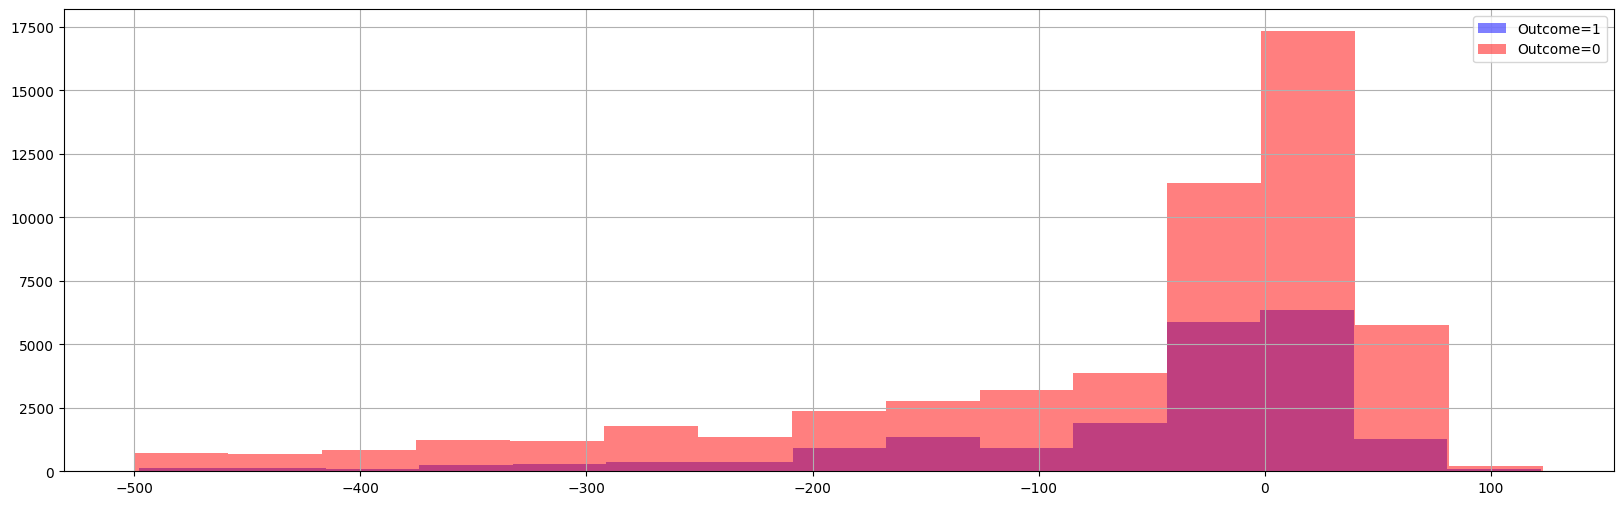

In [ ]:
#regis_cs
plt.figure(figsize=(20,6))
train[train['overall_outcome']==1]['regis_cs'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['regis_cs'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

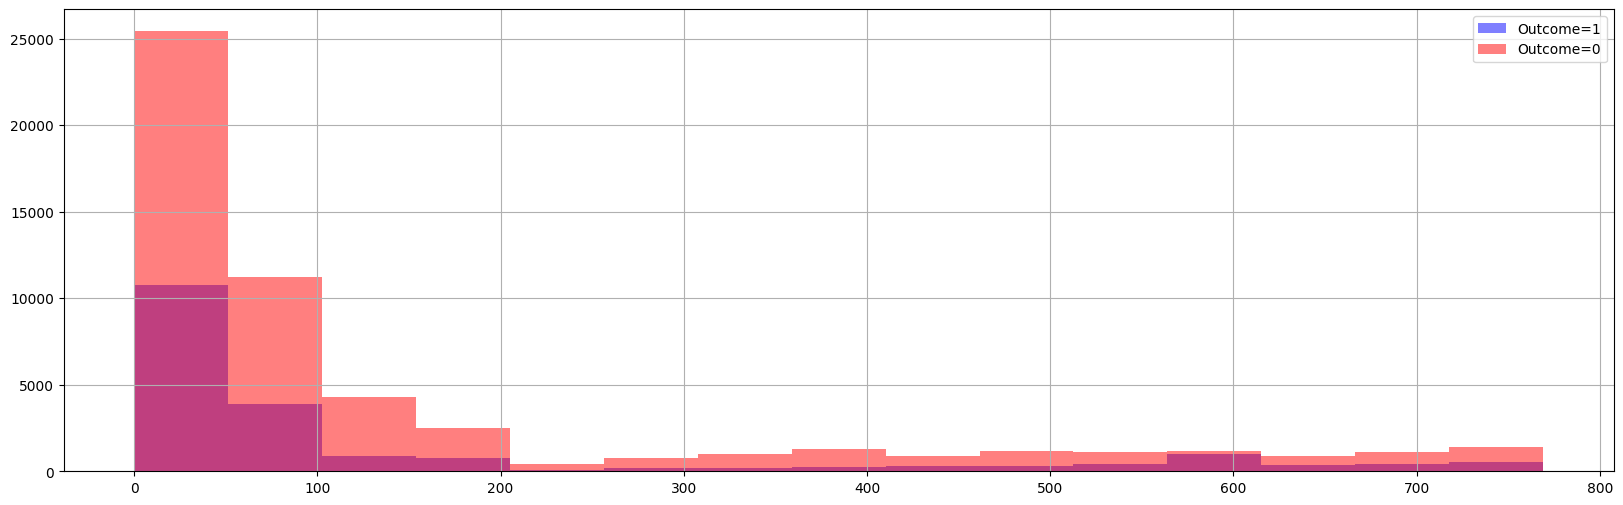

In [ ]:
#regis_ce
plt.figure(figsize=(20,6))
train[train['overall_outcome']==1]['regis_ce'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['regis_ce'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

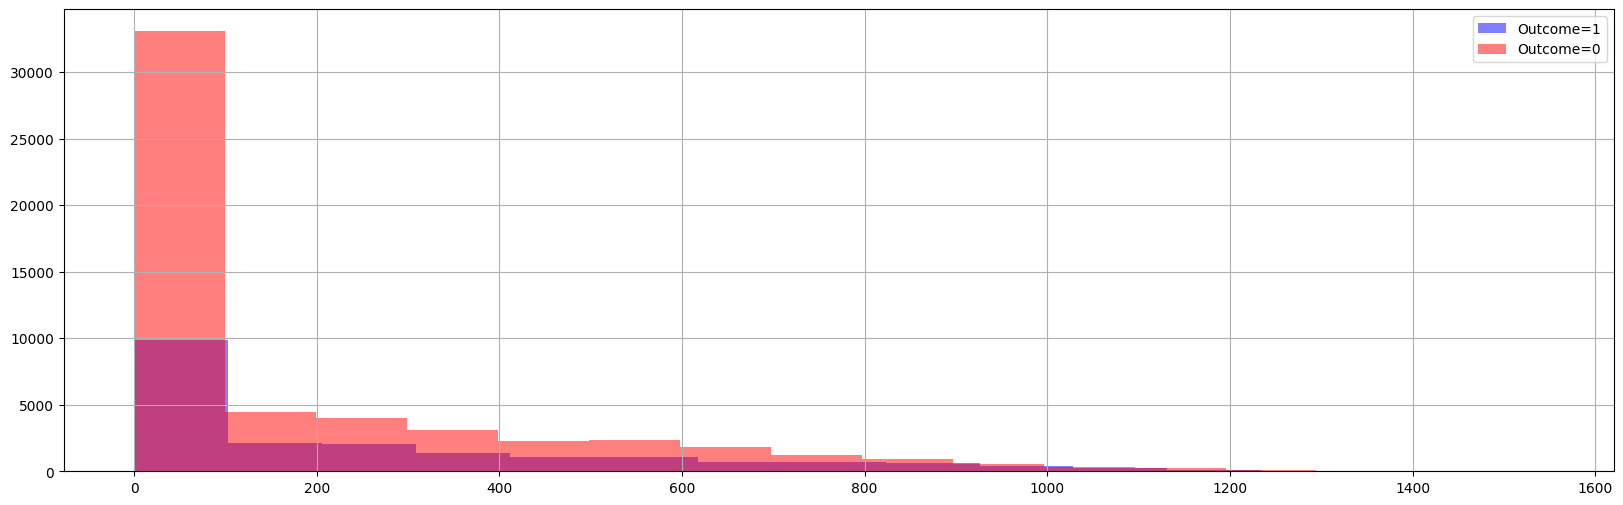

In [ ]:
#regis_fi
plt.figure(figsize=(20,6))
train[train['overall_outcome']==1]['regis_fi'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['regis_fi'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

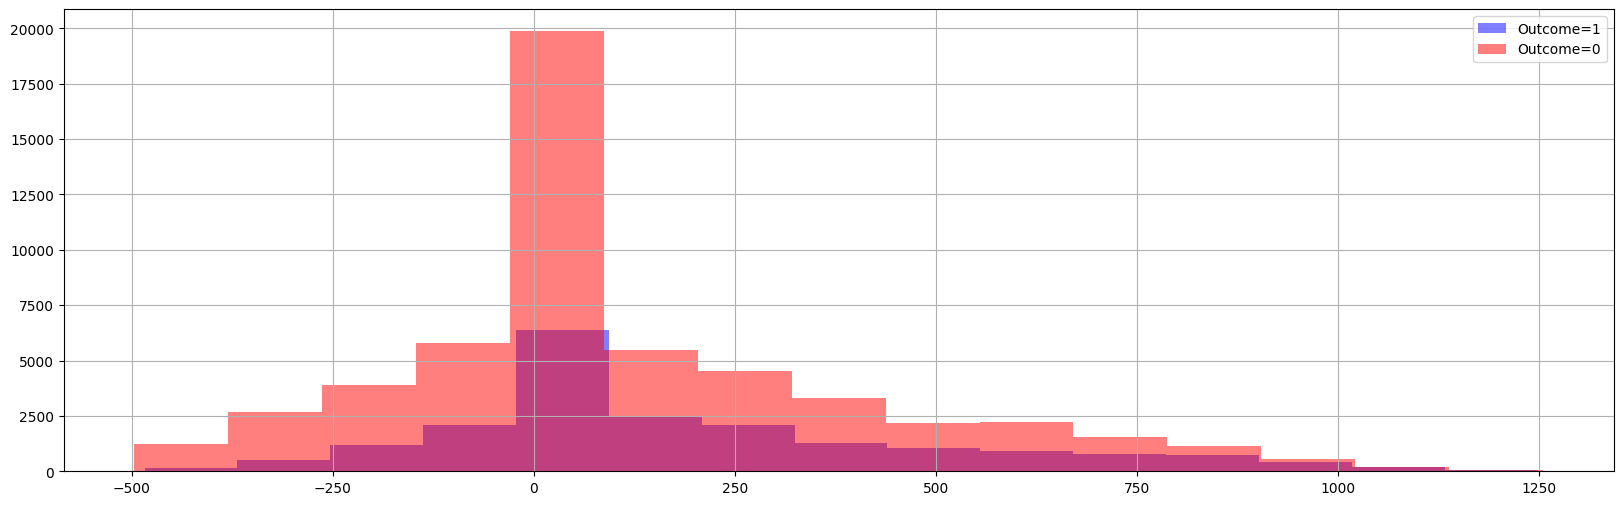

In [ ]:
#fi_cs
plt.figure(figsize=(20,6))
train[train['overall_outcome']==1]['fi_cs'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['fi_cs'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

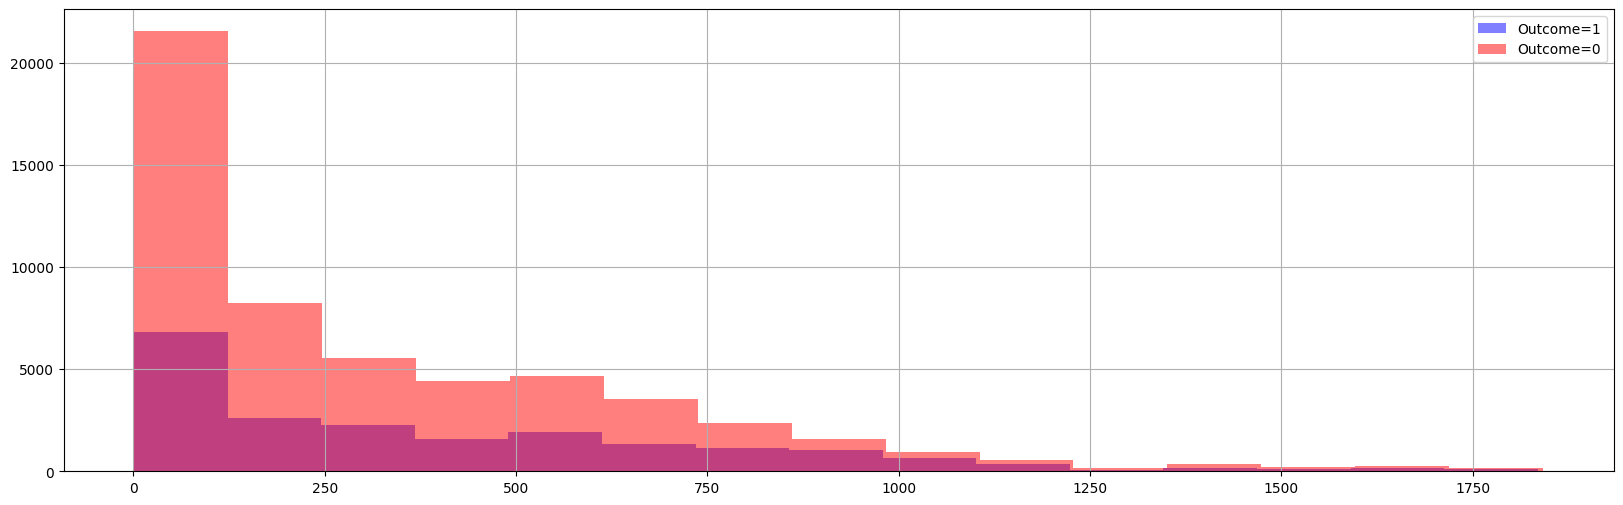

In [ ]:
#fi_ce
plt.figure(figsize=(20,6))
train[train['overall_outcome']==1]['fi_ce'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['fi_ce'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

In [ ]:
train['nos_hc_per_patient']=train.groupby('Patient_ID')['Health_Camp_ID'].transform('nunique')
train['nos_pat_per_health']=train.groupby('Health_Camp_ID')['Patient_ID'].transform('nunique')

test['nos_hc_per_patient']=test.groupby('Patient_ID')['Health_Camp_ID'].transform('nunique')
test['nos_pat_per_health']=test.groupby('Health_Camp_ID')['Patient_ID'].transform('nunique')

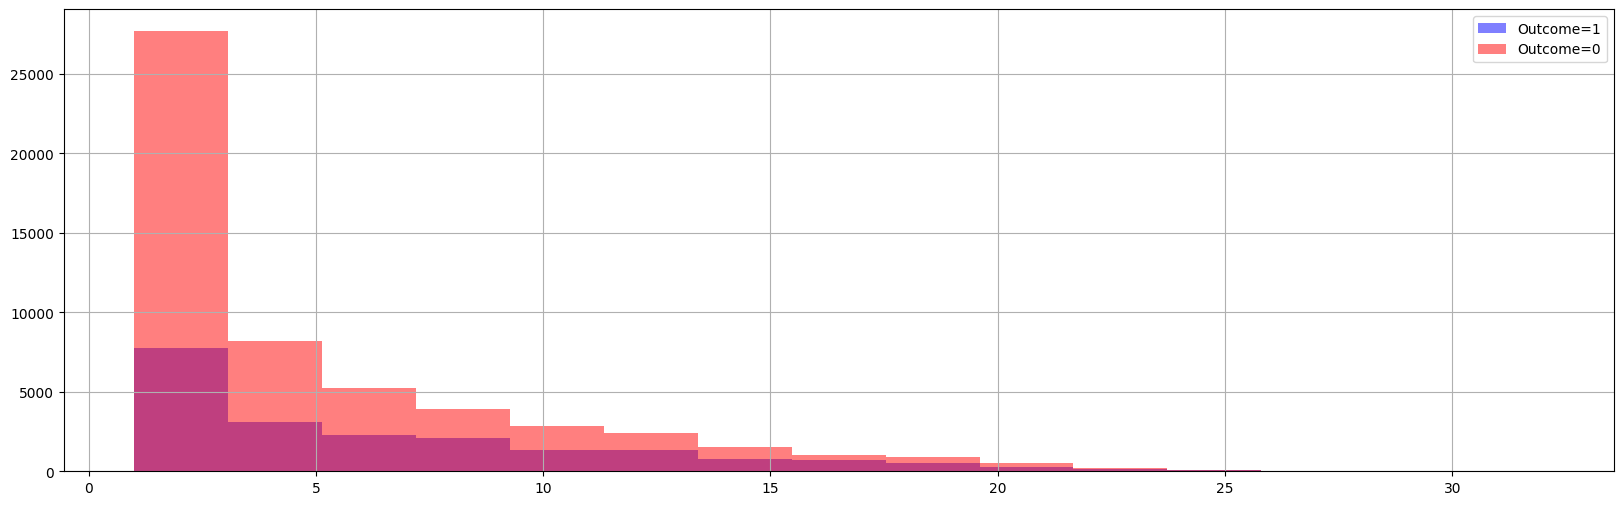

In [ ]:
#nos_hc_per_patient
plt.figure(figsize=(20,6))
train[train['overall_outcome']==1]['nos_hc_per_patient'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['nos_hc_per_patient'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

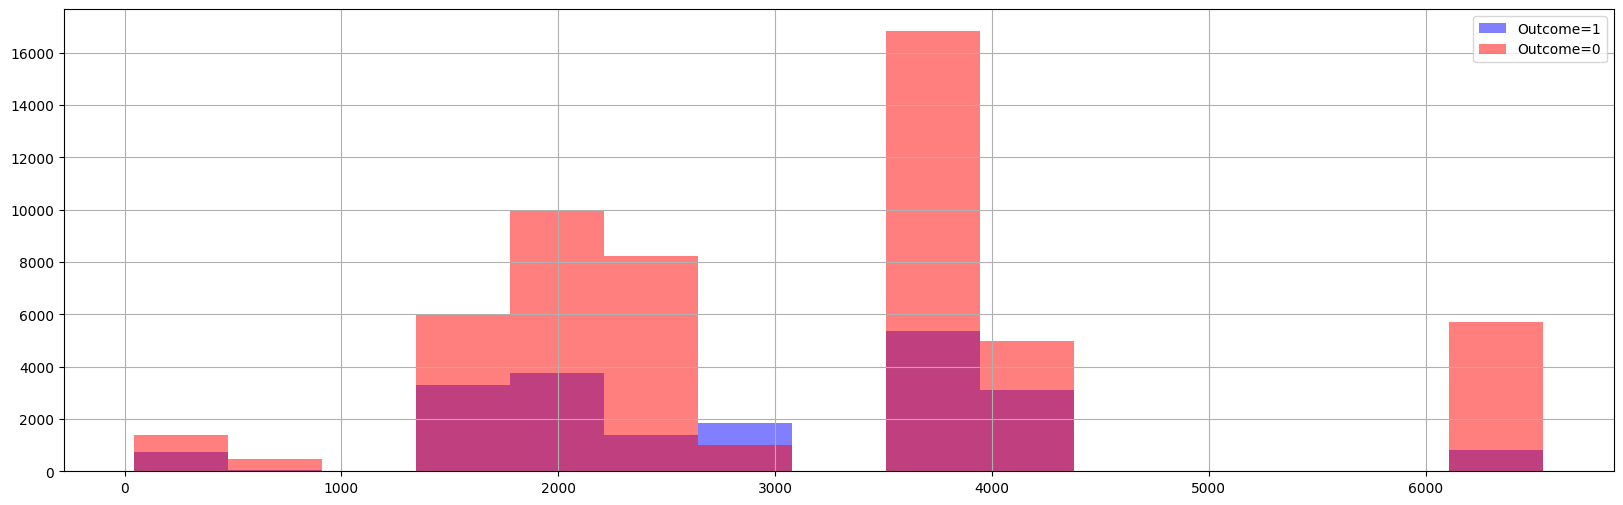

In [ ]:
#nos_pat_per_health
plt.figure(figsize=(20,6))
train[train['overall_outcome']==1]['nos_pat_per_health'].hist(alpha=0.5,color='blue',
                                              bins=15,label='Outcome=1')
train[train['overall_outcome']==0]['nos_pat_per_health'].hist(alpha=0.5,color='red',
                                              bins=15,label='Outcome=0')
plt.legend()

In [ ]:
corr_train=train.drop(['Registration_Date','Camp_Start_Date','Camp_End_Date','Patient_ID','Health_Camp_ID','First_Interaction','Employer_Category'],axis=1).corr()
corr_train.reset_index(inplace=True)
corr_train=corr_train[['index','overall_outcome']]
corr_train['overall_outcome']=corr_train['overall_outcome'].apply(lambda x:abs(x))
corr_train.sort_values(by='overall_outcome',ascending=False,inplace=True)

In [ ]:
independent_variables=corr_train.iloc[1:len(corr_train)//2]['index'] #taking 50% of variables
independent_variables

,index
16,Third_cat1
22,G_cat2
15,Second_cat1
48,Second_cat1_int
21,F_cat2
20,E_cat2
19,D_cat2
12,Camp_End_Day
54,nos_hc_per_patient
46,None_city


## Checking for multicollinearity

#### What is multicollinearity?

Multicollinearity exists whenever an independent variable is highly correlated with one or more of the other independent variables in a multiple regression equation. Multicollinearity is a problem because it undermines the statistical significance of an independent variable.

In [ ]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = [independent_variables.iloc[i] for i in range(len(independent_variables))]
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [ ]:
import numpy as np
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif_safe(df):
    # Keep only numeric columns
    X = df.select_dtypes(include=[np.number]).copy()

    # Replace inf/-inf with NaN
    X.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Drop rows with NaN
    X.dropna(inplace=True)

    # Add constant (required by statsmodels)
    X['const'] = 1.0

    vif = pd.DataFrame()
    vif['feature'] = X.columns
    vif['VIF'] = [
        variance_inflation_factor(X.values, i)
        for i in range(X.shape[1])
    ]

    return vif


In [ ]:
vif_result = calc_vif_safe(train[independent_variables])
print(vif_result)


/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                      feature        VIF
0             Second_cat1_int   1.273341
1                Camp_End_Day   1.343145
2          nos_hc_per_patient   1.510583
3                       fi_cs        inf
4                    regis_fi        inf
5            Camp_End_Quarter  40.449046
6        Registration_Quarter  21.624587
7                       fi_ce   7.390543
8              Camp_End_Month  42.688472
9          Registration_Month  20.649172
10         nos_pat_per_health   2.505872
11                       Var5   2.580095
12        Online_Interactions   1.084053
13         Camp_Start_Quarter  24.138207
14  First_Interaction_Quarter   1.223830
15           Camp_Start_Month  23.330232
16                       Var1   2.350217
17                   regis_cs        inf
18                      const  37.020383


# Model Building 1 - Neural Networks

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score

In [ ]:
X=train[independent_variables]
y=train['overall_outcome']

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74944 entries, 0 to 74943
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Third_cat1                 74944 non-null  bool 
 1   G_cat2                     74944 non-null  bool 
 2   Second_cat1                74944 non-null  bool 
 3   Second_cat1_int            74944 non-null  int64
 4   F_cat2                     74944 non-null  bool 
 5   E_cat2                     74944 non-null  bool 
 6   D_cat2                     74944 non-null  bool 
 7   Camp_End_Day               74944 non-null  int32
 8   nos_hc_per_patient         74944 non-null  int64
 9   None_city                  74944 non-null  bool 
 10  fi_cs                      74944 non-null  int64
 11  regis_fi                   74944 non-null  int64
 12  nan_inc                    74944 non-null  bool 
 13  Camp_End_Quarter           74944 non-null  int32
 14  Registration_Quarter  

In [ ]:
model = Sequential()

# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

# input layer
model.add(Dense(26,  activation='relu'))
model.add(Dropout(0.5))

# hidden layer
model.add(Dense(13,activation='relu'))
model.add(Dropout(0.5))

# output layer
model.add(Dense(units=1,activation='sigmoid'))

# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
model.fit(x=X_train,
          y=y_train,
          epochs=500,
          batch_size=256,
          validation_data=(X_test, y_test),
          callbacks=[early_stop],
          verbose=1
          )

Epoch 1/500
205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.6522 - val_loss: 0.4688
Epoch 2/500
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5133 - val_loss: 0.4522
Epoch 3/500
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4980 - val_loss: 0.4447
Epoch 4/500
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4840 - val_loss: 0.4401
Epoch 5/500
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4765 - val_loss: 0.4391
Epoch 6/500
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4743 - val_loss: 0.4357
Epoch 7/500
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4712 - val_loss: 0.4348
Epoch 8/500
205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4654 - val_loss: 0.4324
Epoch 9/500
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4609 - val_loss: 0.4322
Epoch 10/500
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4625 - val_loss: 0.4297
Epoch 11/500
205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4626 - val_loss: 0.4273
Epoch 12/500
205/205 ━━━━━━━━━━━━━━━━━━━━

## Model Accuracy Checks

<Axes: >

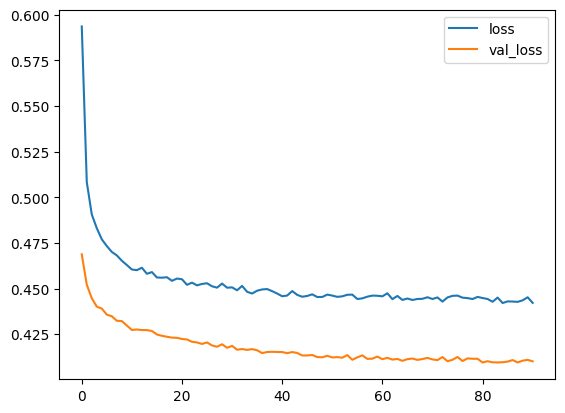

In [ ]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [ ]:
# Predict probabilities
predictions = model.predict(X_test)

# Flatten output
predictions = predictions.ravel()

# Convert to binary classes
y_pred = (predictions >= 0.5).astype(int)


703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
roc_auc_score(y_test, predictions)

np.float64(0.8554519537791401)

/tmp/ipython-input-2041496944.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions,kde=False)


<Axes: >

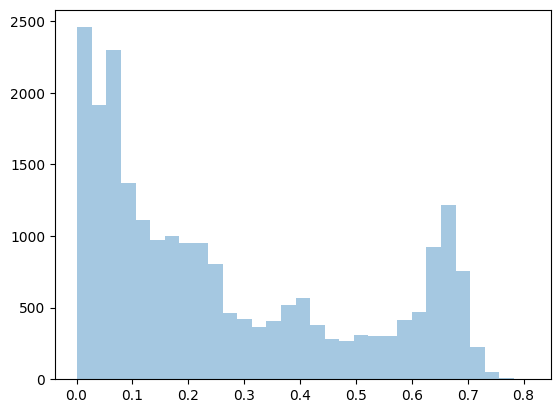

In [ ]:
sns.distplot(predictions,kde=False)

## Checking On Test Data

In [ ]:
# 1. Make sure all training columns exist in test
missing_cols = [col for col in independent_variables if col not in test.columns]

for col in missing_cols:
    # create any missing columns in test with a default value (e.g. 0)
    test[col] = 0

# 2. Reorder test columns to match the training order
test_for_scaler = test[independent_variables]

# 3. Now transform safely
test_scaled = scaler.transform(test_for_scaler)


In [ ]:
# Get probability predictions
predictions = model.predict(test_scaled)

# Convert to 1D array
predictions = predictions.ravel()


1102/1102 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
test['Outcome']=predictions

In [ ]:
output=test[['Patient_ID','Health_Camp_ID','Outcome']]

In [ ]:
output.to_csv('nn.csv',index=False)

## Creating Blended Model

In [ ]:
preds = 0.0

for seed_val in [1, 3, 10, 15, 20, 33, 333, 1997, 2020, 2021]:
    print(seed_val)

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.30, random_state=seed_val
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    model.fit(
        X_train_scaled,
        y_train,
        epochs=500,
        batch_size=256,
        validation_data=(X_val_scaled, y_val),
        callbacks=[early_stop],
        verbose=0
    )

    # scale test data
    test_scaled = scaler.transform(test[independent_variables])

    # KERAS PROBABILITY PREDICTION
    predictions = model.predict(test_scaled).ravel()

    preds += predictions

# average predictions
preds = preds / 10

# final class labels if needed
y_pred = (preds >= 0.5).astype(int)


1
Epoch 16: early stopping
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 1s 701us/step
3
Epoch 11: early stopping
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 1s 690us/step
10
Epoch 16: early stopping
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step
15
Epoch 16: early stopping
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step
20
Epoch 14: early stopping
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step
33
Epoch 11: early stopping
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step
333
Epoch 15: early stopping
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 1s 725us/step
1997
Epoch 11: early stopping
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step
2020
Epoch 12: early stopping
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step
2021
Epoch 11: early stopping
1102/1102 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step


In [ ]:
sub = pd.DataFrame({"Patient_ID":test.Patient_ID.values})
sub["Health_Camp_ID"] = test.Health_Camp_ID.values
sub["Outcome"] =  preds
sub.to_csv("nn_blended.csv", index=False)

# Model Building 2 - Random Forest Classifier

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
tr=train[train['Camp_Start_Date'] <'2005-11-01']
val=train[train['Camp_Start_Date'] >'2005-10-30']

In [ ]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation

# model
clf = LGBMClassifier(
    n_estimators=450,
    learning_rate=0.03,
    random_state=1,
    colsample_bytree=0.5,
    reg_alpha=2,
    reg_lambda=2,
)

# training
clf.fit(
    tr[independent_variables],
    tr["overall_outcome"],
    eval_set=[(val[independent_variables], val["overall_outcome"])],
    eval_metric="auc",
    callbacks=[
        early_stopping(stopping_rounds=100),   # replaces early_stopping_rounds
        log_evaluation(period=50)              # replaces verbose printing
    ],
)


[LightGBM] [Info] Number of positive: 16509, number of negative: 51322
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.050511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1299
[LightGBM] [Info] Number of data points in the train set: 67831, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.243384 -> initscore=-1.134214
[LightGBM] [Info] Start training from score -1.134214
Training until validation scores don't improve for 100 rounds
[50]	valid_0's auc: 0.697498	valid_0's binary_logloss: 0.66655
[100]	valid_0's auc: 0.69958	valid_0's binary_logloss: 0.655009
[150]	valid_0's auc: 0.698079	valid_0's binary_logloss: 0.671319
Early stopping, best iteration is:
[79]	valid_0's auc: 0.700727	valid_0's binary_logloss: 0.651093


LGBMClassifier(colsample_bytree=0.5, learning_rate=0.03, n_estimators=450,
               random_state=1, reg_alpha=2, reg_lambda=2)

## Creating Blended Model

In [ ]:
preds = 0
for seed_val in [1,3,10,15,20,33,333,1997,2020,2021]:
    print (seed_val)
    m=LGBMClassifier(n_estimators=450,learning_rate=0.03,random_state=seed_val,colsample_bytree=0.5,reg_alpha=2,reg_lambda=2)
    m.fit(train[independent_variables],train['overall_outcome'])
    predict=m.predict_proba(test[independent_variables])[:,1]
    preds += predict
preds = preds/10

1
[LightGBM] [Info] Number of positive: 20338, number of negative: 54606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1312
[LightGBM] [Info] Number of data points in the train set: 74944, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271376 -> initscore=-0.987653
[LightGBM] [Info] Start training from score -0.987653
3
[LightGBM] [Info] Number of positive: 20338, number of negative: 54606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1312
[LightGBM] [Info] Number of data points in the train set: 74944, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271376 -> initscore=-0.98765

In [ ]:
sub = pd.DataFrame({"Patient_ID":test.Patient_ID.values})
sub["Health_Camp_ID"] = test.Health_Camp_ID.values
sub["Outcome"] =  preds
sub.to_csv("lgbm_blending1.csv", index=False)

## Featuring Engineering - getting aggregate, got from top solution in AnalyticsVidhya

In [ ]:
train.sort_values(by=['Patient_ID','Registration_Date'],inplace=True)
train['days_since_last_registration'] = train.groupby('Patient_ID')['Registration_Date'].diff().apply(lambda x: x.days)
train['days_since_next_registration'] = train.groupby('Patient_ID')['Registration_Date'].diff(-1) * (-1) / np.timedelta64(1, 'D')

test.sort_values(by=['Patient_ID','Registration_Date'],inplace=True)
test['days_since_last_registration'] = test.groupby('Patient_ID')['Registration_Date'].diff().apply(lambda x: x.days)
test['days_since_next_registration'] = test.groupby('Patient_ID')['Registration_Date'].diff(-1) * (-1) / np.timedelta64(1, 'D')

In [ ]:
def agg_numeric(df, parent_var, df_name):
    """
    Groups and aggregates the numeric values in a child dataframe
    by the parent variable.

    Parameters
    --------
        df (dataframe):
            the child dataframe to calculate the statistics on
        parent_var (string):
            the parent variable used for grouping and aggregating
        df_name (string):
            the variable used to rename the columns

    Return
    --------
        agg (dataframe):
            a dataframe with the statistics aggregated by the `parent_var` for
            all numeric columns. Each observation of the parent variable will have
            one row in the dataframe with the parent variable as the index.
            The columns are also renamed using the `df_name`. Columns with all duplicate
            values are removed.

    """


    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').drop(columns={'Patient_ID', 'Health_Camp_ID','Second_cat1', 'Third_cat1', 'B_cat2', 'C_cat2', 'D_cat2', 'E_cat2',
       'F_cat2', 'G_cat2', '2_cat3','1_inc', '2_inc', '3_inc', '4_inc', '5_inc',
       '6_inc', 'None_inc', 'B_city', 'C_city', 'D_city', 'E_city', 'F_city',
       'G_city', 'H_city', 'I_city', 'None_city'}).copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns

    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]

    return agg

In [ ]:
import pandas as pd
import numpy as np

# ---------- SAFE NUMERIC AGGREGATION FUNCTION ----------
def agg_numeric(df, group_var, df_name):
    """
    Aggregate all numeric columns by `group_var`.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe.
    group_var : str
        Column name to group by (e.g. 'Patient_ID').
    df_name : str
        Prefix to use in the output column names.

    Returns
    -------
    agg : pd.DataFrame
        Dataframe with one row per `group_var` and aggregated stats.
    """

    # keep only numeric columns + the group variable
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if group_var not in numeric_cols:
        numeric_cols.append(group_var)

    df_numeric = df[numeric_cols].copy()

    # group and aggregate
    agg = df_numeric.groupby(group_var).agg(['count', 'mean', 'min', 'max', 'sum'])

    # flatten multi-index columns
    agg.columns = [
        f"{df_name}_{col}_{stat}"
        for col, stat in agg.columns.to_flat_index()
    ]

    # bring group_var back as a normal column
    agg.reset_index(inplace=True)

    return agg
# -------------------------------------------------------


# ---------- USE IT FOR TRAIN & TEST --------------------
# for train
PID_aggregate_train = agg_numeric(train, 'Patient_ID', 'PID')
print("PID aggregate (train) shape:", PID_aggregate_train.shape)
train = train.merge(PID_aggregate_train, on='Patient_ID', how='left')

# for test
PID_aggregate_test = agg_numeric(test, 'Patient_ID', 'PID')
print("PID aggregate (test) shape:", PID_aggregate_test.shape)
test = test.merge(PID_aggregate_test, on='Patient_ID', how='left')
# -------------------------------------------------------


PID aggregate (train) shape: (29750, 171)
PID aggregate (test) shape: (15324, 171)


# Final Submission:

In [ ]:
preds = 0
for seed_val in [1,3,10,15,20,33,333,1997,2020,2021]:
    print (seed_val)
    m=LGBMClassifier(n_estimators=450,learning_rate=0.03,random_state=seed_val,colsample_bytree=0.5,reg_alpha=2,reg_lambda=2)
    m.fit(train[independent_variables],train['overall_outcome'])
    predict=m.predict_proba(test[independent_variables])[:,1]
    preds += predict
preds = preds/10

1
[LightGBM] [Info] Number of positive: 20338, number of negative: 54606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1312
[LightGBM] [Info] Number of data points in the train set: 74944, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271376 -> initscore=-0.987653
[LightGBM] [Info] Start training from score -0.987653
3
[LightGBM] [Info] Number of positive: 20338, number of negative: 54606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1312
[LightGBM] [Info] Number of data points in the train set: 74944, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.271376 -> initscore=-0.98765

In [ ]:
sub = pd.DataFrame({"Patient_ID":test.Patient_ID.values})
sub["Health_Camp_ID"] = test.Health_Camp_ID.values
sub["Outcome"] =  preds
sub.to_csv("lgbm_blending2.csv", index=False)

# References:
1. EDA - https://www.analyticsvidhya.com/blog/2016/01/guide-data-exploration/
2. LightGBM - https://towardsdatascience.com/understanding-lightgbm-parameters-and-how-to-tune-them-6764e20c6e5b